# Predicting loan defaults

## Setup



In [164]:
# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import set_config
from sklearn.metrics import recall_score
from xgboost import XGBClassifier


In [ ]:
# Load data in 
df = pd.read_csv("info.csv")
df.sample(5)

C:\Users\user\AppData\Local\Temp\ipykernel_33648\920101525.py:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("freddiemac.csv")


,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,seller_name,servicer_name,flag_sc,id_loan_rr,program_ind,rr_ind,property_val,io_ind,mi_cancel_ind,loan_status
135630,808,201911,Y,204910,25220.0,0,1,P,80,26,...,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",NaN,NaN,9,NaN,2,N,7,active
86073,740,201811,N,204810,41700.0,0,1,P,80,41,...,Other sellers,"PNC BANK, NA",NaN,NaN,9,NaN,2,N,7,active
136518,698,201911,Y,204910,36260.0,0,1,P,102,35,...,Other sellers,Other servicers,NaN,NaN,F,NaN,2,N,7,prepaid
162964,688,202006,N,205005,45104.0,0,1,P,80,39,...,Other sellers,Other servicers,NaN,NaN,9,NaN,2,N,7,prepaid
36138,801,201711,N,204710,26820.0,0,1,P,59,50,...,Other sellers,NATIONSTAR MORTGAGE LLC DBA MR. COOPER,NaN,NaN,9,NaN,2,N,7,active


In [ ]:
# Seperate the prediction dataset from the original dataset
prediction = df[df['loan_status'] == "active"]
prediction = prediction.drop("loan_status", axis = 1)
prediction_ori = prediction.copy()
# Drop the rows where loan status is active
df = df[df["loan_status"] != "active"]
# Get the response column
df['loan_status'] = df['loan_status'].map({'prepaid': 0, 'default': 1})
y = df["loan_status"]
df = df.drop("loan_status", axis = 1)
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df,
 y, test_size=0.20, random_state=420, stratify=y)


# Introduction

The aim of the analysis is to build a predictive model that is able to identify loan defaults on currently
active loans. The dataset is based on a bank's loan data from January 2017 to May 2022 which
contains data on 200,000 loans with 33 columns. The data was initially split based on the loan status,
where the active loans are used in a prediction set while the prepaid and defaulted loans were used to
train the model. To limit bias within the model, prepaid and defaulted loans were further split into a
train, validation and test sets before exploratory data analysis and stratified on y such that the ratio of
defaults to prepaid within the training and test datasets are the same. This helps with maintaining the
proportion within this highly imbalanced dataset where the number of defaults is significantly smaller
compared to the number of prepaid loans.  

Initial assessment of the data was done to identify features that were irrelevant as well as features that
should be modified. The simplified training dataset was then used to build a predictive model, the XGBoost model. The model was
then compared, with the random forest model performing better than the rest. This model was also
further simplified to reduce the complexity by determining which features were important in
predicting defaults. This final model performed decent at reducing the number of false negatives on the test
data, which is important as the model should aim to correctly identify as many defaults as possible.
The performance of the model was evaluated based on the recall score first, then only the accuracy
score, as false negatives should be minimized to prevent loss of money by the banks.  

Of the possible features explored, the most influential were found to be credit score, debt to income
ratio, combined loan-to-value, interest rates on the loan, and date of first payment.

# Exploratory Data Analysis and Feature Engineering

In [149]:
summary = pd.DataFrame({
 "X_test, Number of unique values": X_test.nunique(), # mostly for categorical
 "X_train, Number of unique values": X_train.nunique(), # mostly for categorical
 "X_train, Number of NAs": X_train.isnull().sum(),
})
display(summary)

,"X_test, Number of unique values","X_train, Number of unique values","X_train, Number of NAs"
fico,243,278,0
dt_first_pi,50,52,0
flag_fthb,2,2,0
dt_matr,262,289,0
cd_msa,420,436,8947
mi_pct,11,14,0
cnt_units,4,4,0
occpy_sts,3,3,0
cltv,116,134,0
dti,51,51,0


Within the dataset, there are loan specific identifiers that do not have significant meaning within the
id_loan and id_loan_rr columns. As these values are always unique without any meaningful
relationship between the values, these columns should be dropped from the dataset. When
considering predictive features that are to be included in the model, the columns with only one
unique value should be removed, as such columns do not provide any additional information.
Therefore, columns such as ppmt_pnlty , prod_type , and io_ind can be simply removed as
these columns only contain a single value. Columns such as flag_sc and rr_ind also appear to
have one unique value but these columns contain a number of NAs as seen in the table above, which
should be treated as a value. In the case of flag_sc , NA values represent loans that do not exceed
loan conforming limits while NA values in rr_ind mean that the loan is not part of a bank's refinance programs. Therefore, these NA values can be replaced with 0s and the non_NA values
can be replaced with 1s such that these columns act as an indicator variable. Similarly to flag_sc
and rr_ind , flag_fthb values are also converted to 1s and 0s such that these columns are
indicator variables.  

Upon examination of the correlation matrix, the pairs dt_matr and orig_loan_term , and ltv
and cltv are very highly correlated (0.98 and 0.99 respectively) as seen in the correlation heatmap
below. Hence, by dropping the former feature in each of these pairs, the remaining features retain the
similar information of the dropped feature. This also prevents issues with colinearity skewing the final
model. ltv was chosen to be dropped since cltv measures the total amount of debt a loanee has,
instead of just with the specific loan considered in the corresponding datapoint. The total debt is more
likely to impact whether or not someone will default on their loans than the debt from one of the
many loans someone may have. dt_matr was dropped instead of orig_loan_term as it is easier
to interpret the how the loan duration may affect defaults as opposed to a date sometime in the
future. There is also a relatively high correlation between cltv and mi_pct (0.66), however this is
not high enough to justify dropping one of these terms.  

While zipcode contains numerical data, the data is actually represented in the format of "XXX00"
where the first three digits correspond to the state and regions within the state. However, grouping
within zipcode would introduce many categorical variables which may result in some categories
having too few points or none at at all, hence the zipcode column is dropped. Similarly,
seller_name and servicer_name would have many categories with big imbalances which would
make the model hard to generalise. While there may be a possibility for the servicer and the seller to
have an effect on the quality of a loan, this would require more data as there are categories which
contain observations with only one response label. There is also no sensible grouping for these sellers
and servicers in balancing out the data and therefore, these two columns can be removed.
Including all 54 states/territories in the st variable would introduce too many factor levels. It makes
sense that whether or not someone will default on their loan is explained by whether or not the
property is in a state or territory in which the foreclosure process has to go through the court system
(i.e. judicial states). All st factor levels were split into a binary classification, with 1 corresponding to a judicial state and 0 otherwise. This reduces complexity whilst
still capturing information explained by geographical location.

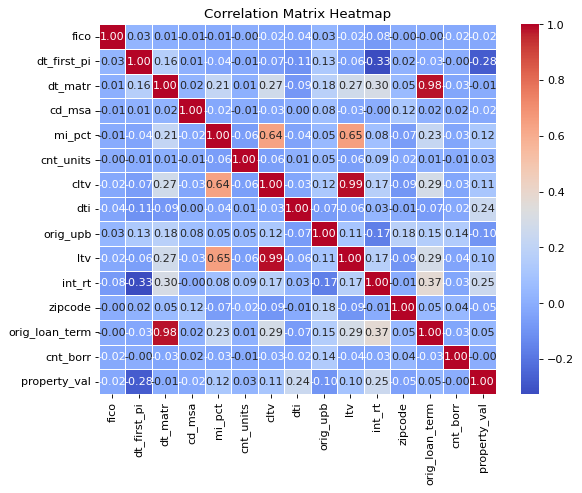

In [150]:
# Plot the correlation matrix
corr = X_train.select_dtypes(include='number').corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show() 

For dti , all values above 65 were considered as not available (and so had a value of 999). These
values were set to 65, since 65 is large for a debt to income ratio and any value above 65 can be
considered as 65 as its impact on default outcomes will be similar. For cd_msa , NA values
correspond to points where either the mortgage property does not come from a metropolitan
statistical area or if this information is unknown, so it was assumed that all of these values did not
come from a metropolitan statistical area. These NA values were converted to 0s, and all other values
were converted to 1s, since too many factor levels would be introduced by including each individual
metropolitan area; it was felt that whether or not the property is from a metropolitan area or not
would be sufficient for the model and any information regarding geographical location is captured
through the st varible.  

To avoid issues with using too many factor levels in categorical data and to capture the continuous
nature of time, dt_first_pi was converted to numerical data by marking the date as the number of
months since December 2016, so that January 2017 has a value of 1, February 2017 has a value of 2,
and so on. This way, we have a metric on how close together 2 dates are, which may be more likely to
have similar outcomes (due to differing economic states at certain time periods, etc.).
The dataset contains rows with missing data, which are indicated with special values or NAs. While the
interpretation of these missing values is clear for some columns, there remain columns where the
interpretation of these missing values are unclear. For example, missing values for fico credit scores
could correspond to scores greater than 850 or less than 300. Therefore, it is unclear if the borrower
has an excellent or poor credit score and imputing a value for these missing values would rely on
unavailable information. Similarly, missing categorical data would be tough to replace as the missing
value could be any of the possible categories. As such, rows with missing values that have an
ambiguous interpretation are removed from the dataset. For the training data, dropping rows with
unavailable data results in removing 84 rows from 82358 to 82274 rows; a small reduction

In [151]:
# Custom functions for FunctionTransformer
def handle_rr_ind(df):
    # Y's are replaced with 1, NaN values are replaced with 0
    df["rr_ind"] = df["rr_ind"].replace('Y', 1).fillna(0).astype(int)
    return df

def handle_flag_sc(df):
     # Y's are replaced with 1, NaN values are replaced with 0
    df["flag_sc"] = df["flag_sc"].replace('Y', 1).fillna(0).astype(int)
    return df

def handle_cd_msa(df):
    # Non numeric values (NA) are converted to 0, else it is converted to 1
    df['cd_msa'] = df['cd_msa'].notna().astype(int)
    return df

def handle_flag_fthb(df):
    # N's are replaced with 0, Y's are replaced with 1
    df['flag_fthb'] = df['flag_fthb'].replace({'N': 0, 'Y': 1}).astype(int)
    return df

def label_judicial_states(state):
    # Convert the state codes to 1 if its a judicial state, and 0 if its
    # a non-judicial state
    judicial_states = ["CT", "DE", "FL", "GU", "IA", "IL", "IN", "KS", "KY", "LA", "ME",
    "ND", "NJ", "NY", "OH", "PA", "PR", "SC", "VI", "VT", "WI"]
    non_judicial_states = ["AK", "AL", "AR", "AZ", "CA", "CO", "DC", "GA", "HI", "ID",
    "MA", "MD", "MI", "MN", "MO", "MS", "MT", "NC", "NE",
    "NH", "NM", "NV", "OK", "OR", "RI", "SD", "TN", "TX",
    "UT", "VA", "WA", "WV", "WY"]
    if state in judicial_states:
        return 1
    elif state in non_judicial_states:
        return 0

def handle_states(df):
    df['st'] = df['st'].apply(label_judicial_states)
    df = df.rename(columns={"st": "judicial_states"})
    return df

def months_since_201612(yyyymm):
    # Converts a single date in YYYYMM format into the
    # number of months after December 2016 (1 being January 2017)
    year = yyyymm // 100
    month = yyyymm % 100
    return (year - 2017) * 12 + month

def handle_dt_first_pi(df):
    # Replaces column for first payment date, to months since December 2016
    df['dt_first_pi'] = df['dt_first_pi'].apply(months_since_201612)
    df = df.rename(columns={"dt_first_pi": "months_since_201612"})
    return df

def handle_dti(df):
    df["dti"] = df["dti"].replace(999, 65)
    return df

def drop_columns(df):
    # Drop unwanted columns
    col_to_drop = ["dt_matr", "ltv", "ppmt_pnlty", "prod_type", "zipcode", "id_loan",
    "seller_name", "servicer_name", "id_loan_rr", "io_ind"]
    return df.drop(col_to_drop, axis = 1)

def drop_unavailable_data(df, y = None):
    # Function to remove all the unavailable data (9, 99, 999, 9999)
    # A map of the columns with their corresponding value for unavailable data
    # Don't drop the rows that are 9's for program_ind and 999 for dti
    missing_value_map = {
        9: ['flag_fthb', 'occpy_sts', 'channel', 'loan_purpose',
            'property_val', 'mi_cancel_ind'],
        99: ['cnt_units', 'prop_type'],
        999: ['mi_pct', 'cltv'],
        9999: ['fico']
    }
    rows_to_drop = set()
    for missing_value, cols in missing_value_map.items():
        for col in cols:
        # Find indices for each column that corresponds to missing/unavailable data
            bad_indexes = df[df[col] == missing_value].index
        # Add the unavailable row indices to the set
            rows_to_drop.update(bad_indexes)
    # Drop all rows that have unavailable data
    df = df.drop(index = rows_to_drop)
    if y is not None:
        y = y.drop(index = rows_to_drop)
        return df,y
    return df

def custom_cleaning(df):
    df = handle_rr_ind(df)
    df = handle_flag_sc(df)
    df = handle_cd_msa(df)
    df = handle_flag_fthb(df)
    df = handle_states(df)
    df = handle_dt_first_pi(df)
    df = handle_dti(df)
    df = drop_columns(df)
    return df 


In [152]:
class_col = 'loan_status'
cat_features = ['occpy_sts', 'channel', 'prop_type',
 'loan_purpose', 'program_ind','mi_cancel_ind']
n_features = len(cat_features)
df_barchart = pd.concat([X_train,y_train], axis=1)
df_barchart = drop_unavailable_data(df_barchart)
df_barchart = custom_cleaning(df_barchart)

C:\Users\user\AppData\Local\Temp\ipykernel_33648\1357853042.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["rr_ind"] = df["rr_ind"].replace('Y', 1).fillna(0).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_33648\1357853042.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["flag_sc"] = df["flag_sc"].replace('Y', 1).fillna(0).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_33648\1357853042.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

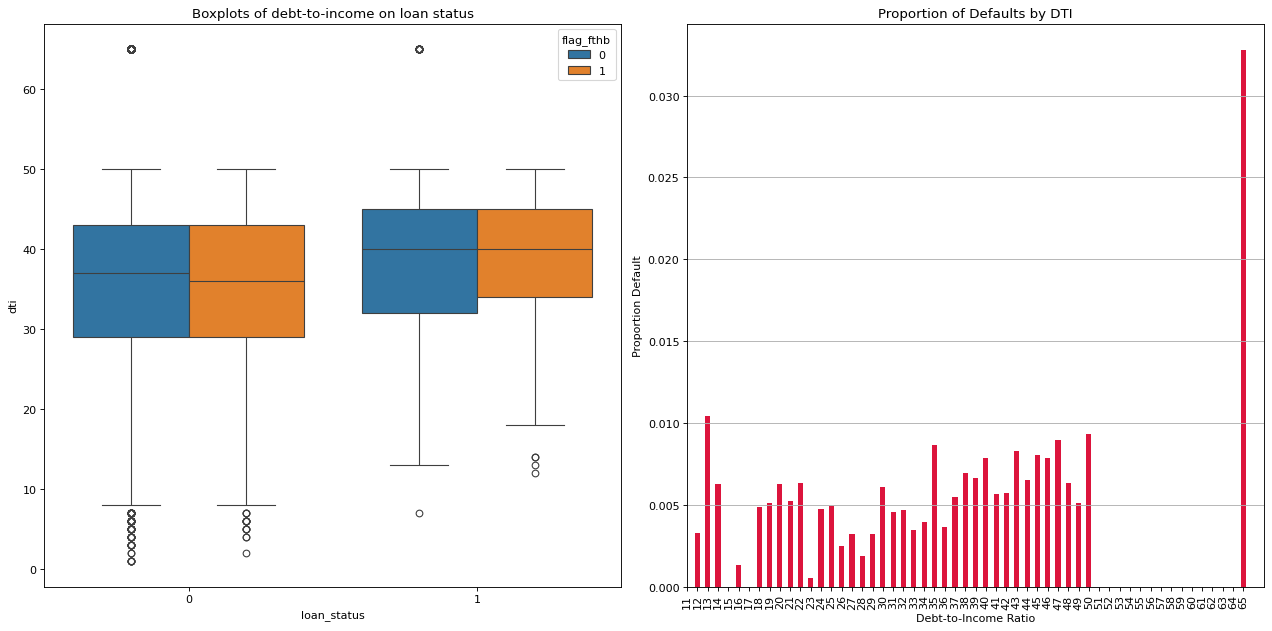

In [153]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
sns.boxplot(data=df_barchart, x="loan_status", y="dti", hue="flag_fthb", ax=axes[0])
axes[0].set_title("Boxplots of debt-to-income on loan status")
default_rate_by_dti = df_barchart.groupby('dti')['loan_status'].mean().sort_index()
# Build full DTI index to preserve spacing
min_dti = int(df_barchart['dti'].min())
max_dti = int(df_barchart['dti'].max())
full_dti_index = pd.Index(range(min_dti, max_dti + 1))
# fill gap
default_rate_by_dti = default_rate_by_dti.reindex(full_dti_index)
default_rate_by_dti.plot(kind='bar', color='crimson', ax=axes[1])
axes[1].set_title("Proportion of Defaults by DTI")
axes[1].set_xlabel("Debt-to-Income Ratio")
axes[1].set_ylabel("Proportion Default")
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_xlim(10, 66)
axes[1].grid(axis='y')
plt.tight_layout()
plt.show()



The boxplot demonstrates that the spread of debt-to-income (dti) for defaulted loans and prepaid
loans are relatively similar but with prepaid loans (0) having a larger spread towards the lower values
of dti. This is likely due the the larger availability of prepaid loan data compared to defaulted loans.
The means of each box plot appear to overlap between prepaid and defaulting loans, suggesting that
while higher dti corresponds to defaulting, the difference is not significant. However, this initial
interpretation should be validated with the model. Additionally, it is worth noting that dti values of 65
(imputed to represent missing dti values of 65 and above) are only available for non first time home
buyers, as shown with the points above the blue boxplots. This suggests that there are special
considerations for allowing non first time home buyers to take on loans while having a high dti.
Compared to the other dti values, the proportion of defaults appear to be significantly higher for
these loans where the loanee has a dti value of 65 or above, suggesting that these loans are riskier.


In [ ]:
# Drop unavailable data
x_y_train = drop_unavailable_data(X_train, y_train)
X_train = x_y_train[0]
y_train = x_y_train[1]
x_y_test = drop_unavailable_data(X_test, y_test)
X_test = x_y_test[0]
y_test = x_y_test[1]
X_prediction = drop_unavailable_data(prediction)
# Assign a handler to each preprocessing function
handler_rr_ind = FunctionTransformer(handle_rr_ind)
handler_flag_sc = FunctionTransformer(handle_flag_sc)
handler_cd_msa = FunctionTransformer(handle_cd_msa)
handler_flag_fthb = FunctionTransformer(handle_flag_fthb)
handler_states = FunctionTransformer(handle_states)
handler_dt_first_pi = FunctionTransformer(handle_dt_first_pi)
handler_dti = FunctionTransformer(handle_dti)
handler_drop_columns = FunctionTransformer(drop_columns)
cleaning_transformer = FunctionTransformer(custom_cleaning)

In [ ]:
# Columns that are categorical and have 3 or more categories
one_hot_col = [6, 11, 13, 14, 18, 21]
# Columns that are numeric, to be scaled
scale_col = [0, 1, 4, 7, 8, 9, 10, 15]
set_config(transform_output="pandas")
# Pipeline for preprocessing the data
preprocessing_pipeline = Pipeline([
    ('handle_rr_ind', handler_rr_ind),
    ('handle_flag_sc', handler_flag_sc),
    ('handle_cd_msa', handler_cd_msa),
    ('handle_flag_fthb', handler_flag_fthb),
    ('handle_states', handler_states),
    ('handle_dt_first_pi', handler_dt_first_pi),
    ('handle_dti', handler_dti),
    ('drop_columns', handler_drop_columns)
])

# Pipeline for standard scaling on numerical columns,
# and one-hot encoding for categorical variables
encode_scale_pipeline = ColumnTransformer(
    transformers = [
        ("num_scale", StandardScaler(), scale_col),
        ("cat_encode", OneHotEncoder(sparse_output=False, drop="first"), one_hot_col)
    ],
    remainder = "passthrough"
)

# Stack the two pipelines together
full_preprocessing_pipeline = Pipeline([
    ("preprocessing", preprocessing_pipeline),
    ("encode_scale", encode_scale_pipeline)
])

# Preprocess the X_train, X_val, and X_test
X_train = full_preprocessing_pipeline.fit_transform(X_train)
X_test = full_preprocessing_pipeline.transform(X_test)
prediction = full_preprocessing_pipeline.transform(prediction)


C:\Users\user\AppData\Local\Temp\ipykernel_33648\1357853042.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["rr_ind"] = df["rr_ind"].replace('Y', 1).fillna(0).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_33648\1357853042.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["flag_sc"] = df["flag_sc"].replace('Y', 1).fillna(0).astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_33648\1357853042.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To reta

# Model Fitting and Tuning

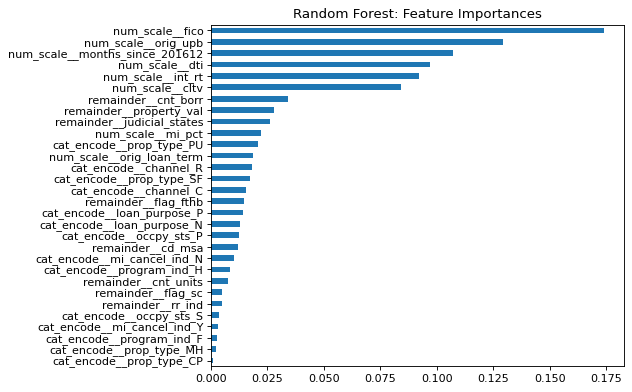

In [156]:
model_pipeline = ImPipeline([
    ("undersampler", RandomUnderSampler(random_state=42)),
    ("classifier", RandomForestClassifier(random_state=42))
])

model_pipeline.fit(X_train, y_train)
rf_model = model_pipeline.named_steps['classifier']
feature_names = rf_model.feature_names_in_
# Create a pandas series with the feature importances
importances = pd.Series(
 rf_model.feature_importances_, index=feature_names
).sort_values(ascending=True)
# Plot the feature importances
ax = importances.plot.barh()
ax.set_title("Random Forest: Feature Importances")
ax.figure.tight_layout()


In [ ]:
# Only take the 6 most important features
X_train = X_train[["num_scale__fico", "num_scale__orig_upb", "num_scale__dti",
 "num_scale__cltv", "num_scale__months_since_201612", "num_scale__int_rt"]]
X_test= X_test[["num_scale__fico", "num_scale__orig_upb", "num_scale__dti",
 "num_scale__cltv", "num_scale__months_since_201612", "num_scale__int_rt"]]
prediction = prediction[["num_scale__fico", "num_scale__orig_upb", "num_scale__dti",
 "num_scale__cltv", "num_scale__months_since_201612", "num_scale__int_rt"]]


In [ ]:
# Grid search over a set parameter grid to get the best set of parameter values
param_grid = {
    'classifier__n_estimators': [500, 750],
    'classifier__learning_rate': [0.5, 1],
    'classifier__max_depth': [5, 10],
    'classifier__reg_alpha': [0.5, 1],
    'classifier__reg_lambda': [0.5, 1],
}


xgb_pipeline = ImPipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss'
    ))
])

cv = KFold(5, shuffle = True, random_state = 42)
n_tuning = GridSearchCV(xgb_pipeline,
    param_grid = param_grid,
    #Evaluation metrics to compute on validation sets
    scoring={'accuracy':'accuracy','f1':'f1','recall':'recall','precision':'precision'},
    cv = cv,
    # Refits the best model on the entire dataset using the recall metric
    refit = "recall",
    return_train_score = True)

n_tuning.fit(X_train, y_train)
print("Best parameter value: ", n_tuning.best_params_)


Best parameter value:  {'classifier__learning_rate': 0.5, 'classifier__max_depth': 10, 'classifier__n_estimators': 500, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 0.5}


Accuracy: 0.6605055292259083
Recall: 0.7142857142857143


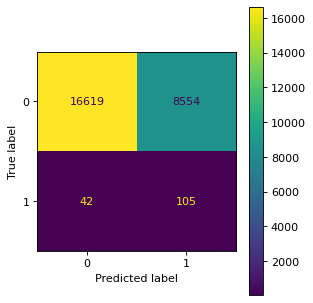

In [162]:
# Define pipeline
xgb_pipeline = ImPipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        learning_rate = 0.5,
        max_depth = 5, 
        n_estimators = 500,
        reg_alpha = 1,
        reg_lambda = 0.5
    ))
])

# Fit pipeline
xgb_pipeline.fit(X_train, y_train)

y_test_pred = xgb_pipeline.predict(X_test)

# Compute metrics
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))


fig, ax = plt.subplots(figsize=(4, 4))
ConfusionMatrixDisplay.from_estimator(xgb_pipeline, X_test, y_test, ax=ax)
plt.tight_layout()
plt.show()


# Discussion & Conclusions

With the goal of predicting the defaults from the dataset, relevant features within the data were
modified and used to build and compare models. The model used was the
XGBoost that was fitted on a dataset that had 6 features, and these features are the
credit score, original unpaid balance, debt-to-income ratio, combined loan-to-value, months since
December 2016 (date of first payment), and the interest rate of the loan. The parameters for the final
model are learning rate = 0.5, max depth = 5, n_estimators = 500, reg_alpha = 1 and reg_lambda = 0.5. The model has a recall score of 71.4%, at
the expense of an accuracy score of 66%. From a bank's point-of-view, this is ideal as false negatives should be minimized.  

From the model that was used, the feature that is the most important when it comes to
predicting whether someone defaults or not is the credit score. The next most significant feature to predict defaults
is the debt-to-income ratio. While initial exploratory data analysis showed that the effect of debt-to-income
based on the boxplots may not be too significant, the model suggests otherwise such that the debt to-income value are of high importance in predicting defaults. Considering that debt-to-income is an
important feature, it is advisable for the finance company in charge to evaluate the profitability of buying loans where
the loanee has a debt-to-income ratio of 65 and above, considering the additional risk of default.  

Overall, this model provides a good insight into how likely someone is to default on their loan. A
major advantage of the simplicity of the model is that only a few variables (6, to be exact) are required
to predict an outcome of a loan. However, there are some limitations and any outputs from the model
need to be taken with caution. The original dataset has a significantly high class imbalance for the
outcome, which affects the way the model is trained. Approaches involving undersampling result in losing significant amounts of
data as the minority class is small, resulting in some underfitting. While the model aims to balance this
by tuning the parameters, the model still suffers from some level of underfitting due to the
undersampling. To reduce this class imbalance and therefore improve the model much more data
needs to be gathered, particularly on loans which have defaulted.
